In [32]:
from SLiCAPnotebook import *
projectPath = '/mnt/DATA/Cursussen/Publish/Books/CSstage/SLiCAP/'
# Always run SLiCAP from the project directory, this will use the correct path settings.
os.chdir(projectPath)
t1=time()

Warning less than two connections at node: 'out'.
No errors found for circuit: 'CS stage resistive noise' from file: 'CSresNoise.cir'.



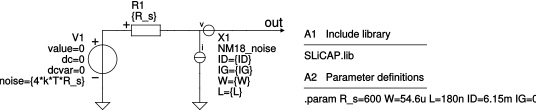

In [33]:
prj = initProject('CS stage noise with resistive source')
fileName = 'CSresNoise.cir'
i1 = instruction()
i1.checkCircuit(fileName)
SVG(filename = img2html('CSresNoise.svg', 800))

In [34]:
HTML(netlist2html(fileName))

In [35]:
# Set value of 1/f noise to zero and define drain current at critical inversion
i1.simType = 'numeric'
i1.defPar('KF_X1', 0)
I_D     = i1.getParValue('ID')
IC      = i1.getParValue('IC_X1')
IC_CRIT = i1.getParValue('IC_CRIT_X1')
I_D     = I_D*IC_CRIT/IC
i1.defPar('ID', I_D)

In [36]:
HTML(elementData2html(i1.circuit))

RefDes,Nodes,Refs,Model,Param,Symbolic,Numeric
F1_X1,1 0 10_X1 0,,F,value,$$\frac{s}{2 \pi f_{T X1}}$$,$$4.45 \cdot 10^{-12} s$$
H1_X1,1 out 1_X1 10_X1,,H,value,$$\frac{1}{g_{m X1}}$$,$$46.79$$
I1_X1,0 1_X1,,I,noise,$$\frac{4 T k}{R_{N X1}} \left(1 + F_{X1}^{- AF_{X1}} f_{\ell X1}\right)$$,$$3.162 \cdot 10^{-22}$$
,,,,value,$$0$$,$$0$$
I2_X1,1 0,,I,noise,$$2 IG q$$,$$0$$
,,,,value,$$0$$,$$0$$
R1,2 1,,R,value,$$R_{s}$$,$$600.0$$
V1,2 0,,V,noise,$$4 R_{s} T k$$,$$9.941 \cdot 10^{-18}$$
,,,,dc,$$0$$,$$0$$
,,,,value,$$0$$,$$0$$


In [37]:
HTML(params2html(i1.circuit))

Name,Symbolic,Numeric
$$ID$$,$$0.006169$$,$$0.006169$$
$$IG$$,$$0$$,$$0$$
$$L$$,$$1.8 \cdot 10^{-7}$$,$$1.8 \cdot 10^{-7}$$
$$R_{s}$$,$$600$$,$$600.0$$
$$T$$,$$300$$,$$300.0$$
$$U_{T}$$,$$\frac{T k}{q}$$,$$0.02585$$
$$W$$,$$5.46 \cdot 10^{-5}$$,$$5.46 \cdot 10^{-5}$$
$$c$$,$$2.998 \cdot 10^{8}$$,$$2.998 \cdot 10^{8}$$
$$\epsilon_{0}$$,$$\frac{1}{c^{2} \mu_{0}}$$,$$8.854 \cdot 10^{-12}$$
$$\epsilon_{SiO2}$$,$$3.9$$,$$3.9$$


In [38]:
R_N   = i1.getParValue('R_N_X1')
R_s   = i1.getParValue('R_s')
f_T   = i1.getParValue('f_T_X1')
g_m   = i1.getParValue('g_m_X1')
Width = i1.getParValue('W')

In [39]:
htmlPage('Noise analysis')

Plot "Inoise.svg" saved to disk.


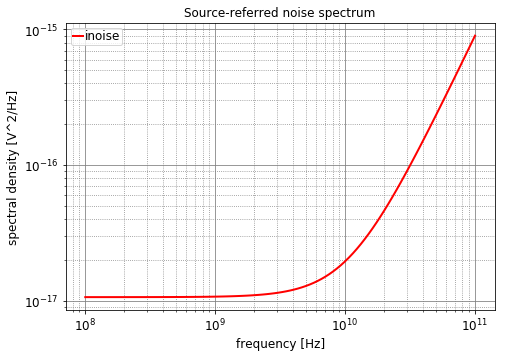

In [40]:
i1.source   = 'V1'
i1.detector = 'V_out'
i1.gainType = 'vi'
i1.dataType = 'noise'
i1.simType  = 'numeric'
noiseResult = i1.execute()
plotNoise('Inoise', 'Source-referred noise spectrum', noiseResult, 1e8, 1e11, 100, noise = 'inoise', show=True)

In [41]:
# Calculate the noise figure at critical inversion and the given width
totInoise    = rmsNoise(noiseResult, 'inoise', 1e9, 5e9)
totInoiseSrc = rmsNoise(noiseResult, 'inoise', 1e9, 5e9, source=noiseResult.source)
HTML(noise2html(noiseResult))

In [42]:
NF           = 20*sp.log(totInoise/totInoiseSrc)/sp.log(10)
print("The noise figure equals: %s [dB]."%(sp.N(NF, ini.disp)))

The noise figure equals: 0.6526 [dB].


Plot "noiseFigure_W.svg" saved to disk.


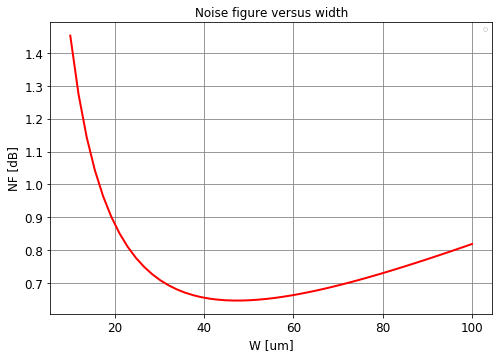

In [43]:
# Below the slow numeric way of plotting the noise figure versus the width
t2 = time()
W              = sp.Symbol('W')
i1.defPar('ID', I_D*W/Width)
i1.stepVar     = 'W'
i1.stepStart   = '10u'
i1.stepStop    = '100u'
i1.stepNum     = 50
i1.step        = True
i1.stepMethod  = 'lin'
noiseSpectra   = i1.execute()
data           = goalFunc()
data.type      = 'NF'
data.ylinlog   = 'lin'
data.noiseType = 'inoise'
data.fmin      = 1e9
data.fmax      = 5e9
data.ylabel    = 'NF'
data.yunits    = 'dB'
data.punits    = 'm'
data.pscale    = 'u'
plotVsStep('noiseFigure_W', 'Noise figure versus width', noiseSpectra, data, show=True)

In [44]:
t3 = time()
print t3-t2, 's'

31.966176033 s


In [45]:
t4 = time()
i1.step = False # turn off parameter stepping
i1.delPar('W')  # delete the numeric definition of the width
noiseW = i1.execute() # calculate the noise spectra as a function of W and f
# Calculate the noise figure as a function of W over the frequency range of interest
RMSnoiseW       = rmsNoise(noiseW, 'inoise', 1e9, 5e9)
RMSnoiseWsource = rmsNoise(noiseW, 'inoise', 1e9, 5e9, noiseW.source)
# Remove the square root before solving
NF_W            = (RMSnoiseW/RMSnoiseWsource)**2
# Find the optimum noise by solving d(NF_W)/dW with sympy (sp)
Wopt            = sp.solve(sp.diff(NF_W, W) ,W)
# The sympy solve function returns a list with solutions. We will copy positive solutions to the list W_opt and 
# print a unique positive solution (second order), or the list with multiple solutions (higher order).
W_opt           = []
for width in Wopt:
    if width > 0:
        W_opt.append(width)
if len(W_opt) == 0:
    print "Did not find an optimum width"
elif len(W_opt) == 1:
    print "Found W_opt=", sp.N(width*1e6, ini.disp), "um"
else:
    print "Found multiple solutions for W_opt:", W_opt

Found W_opt= 47.38 um


In [46]:
HTML('$' + sp.latex(roundN(sp.expand(NF_W), numeric=True)) + '$')

Plot "NF.svg" saved to disk.


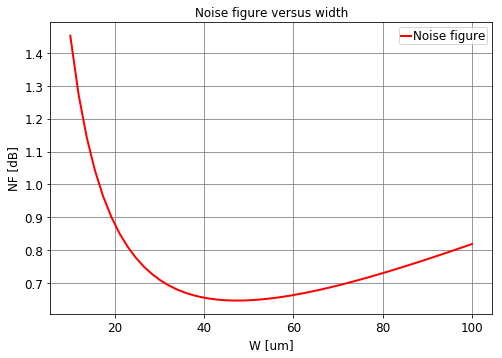

1.7684969902 s


In [47]:
fw = func()
fw.expr = 10*sp.log(NF_W)/sp.log(10)
fw.xVar = W
fw.xscale = 'u'
fw.yscale = ''
fw.xunits = 'm'
fw.ylabel = 'NF'
fw.yunits = 'dB'
fw.fname  = 'Noise figure'
plotFunction('NF', 'Noise figure versus width', fw, 10, 100, 50, show = True)
t5 = time()
print t5-t4, 's'